## HW2 Solution Part 1

**step1**: get keypoints for each images

**step2**: get patches for each keypoints

**step3**: get descriptions for each keypoints (by forward pass patches to the network)

step4: caculate the similarity matrices

step5: get topK similar images for each query

step6: draw recall vs precision curves

---

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# load packages
from __future__ import division, print_function
import glob
import os
import cv2
import PIL
import random
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64
from scipy.optimize import linear_sum_assignment
np.set_printoptions(suppress=True)



In [19]:
# parameters setting
#stero_images_path = "stereo/"
#image_num = 10 #number of images
#kps_num = 100 #number of keypoints we want to detect 
#patch_size = 32
#patches = torch.zeros(image_num, kps_num,1, patch_size, patch_size)

# parameters setting
query_path = "stereo/image1/"
image_path = "stereo/image2/"
query_num = 5
image_num = 5
kps_num = 100 #number of keypoints we want to detect 
patch_size = 32
patches = torch.zeros(query_num+image_num, kps_num,1, patch_size, patch_size)

In [20]:
# Initiate SURF detector
surf = cv2.xfeatures2d.SURF_create(kps_num)

In [21]:
def getPatches(kps, img, size=32, num=500):
    res = torch.zeros(num, 1, size, size)
    if type(img) is np.ndarray:
        img = torch.from_numpy(img)
    h, w = img.shape      # note: for image, the x direction is the verticle, y-direction is the horizontal...
    for i in range(num):
        cx, cy = kps[i]
        cx, cy = int(cx), int(cy)
        dd = int(size/2)
        xmin, xmax = max(0, cx - dd), min(w, cx + dd ) - 1
        ymin, ymax = max(0, cy - dd), min(h, cy + dd ) - 1 
        
        xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)-1
        ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)-1

        res[i, 0, ymin_res: ymax_res, xmin_res: xmax_res] = img[ymin: ymax, xmin: xmax]
    return res

In [5]:
def getPatches(kps, img, size=32, num=500):
    res = torch.zeros(num, 1, size, size)
    if type(img) is np.ndarray:
        img = torch.from_numpy(img)
    h, w = img.shape      # note: for image, the x direction is the verticle, y-direction is the horizontal...
    for i in range(num):
        cx, cy = kps[i]
        cx, cy = int(cx), int(cy)
        dd = int(size/2)
        xmin, xmax = max(0, cx - dd), min(w, cx + dd ) - 1
        ymin, ymax = max(0, cy - dd), min(h, cy + dd ) - 1 
        
        xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)-1
        ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)-1

        res[i, 0, ymin_res: ymax_res, xmin_res: xmax_res] = img[ymin: ymax, xmin: xmax]
    return res

## Detection of the keypoints in all the images with SIFT - Getting the patches 


Images 1: coordinates pi


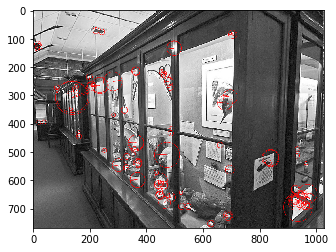

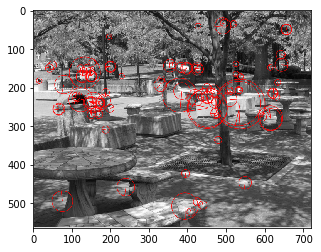

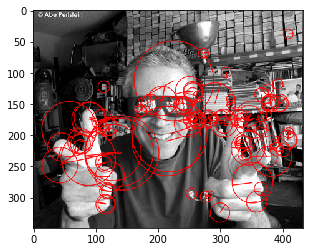

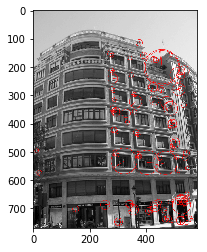

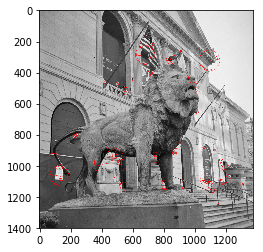

Images 2; coordinates qi


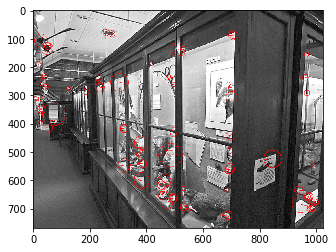

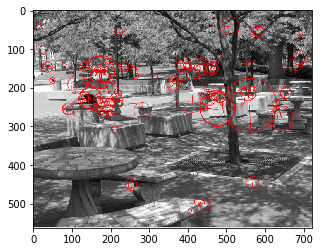

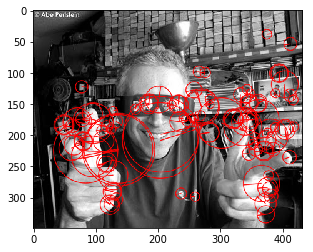

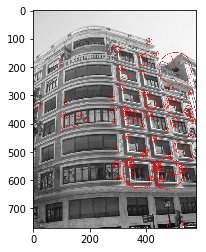

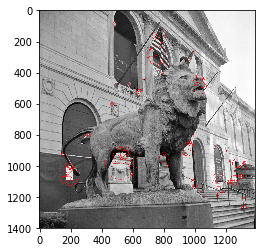

torch.Size([10, 100, 1, 32, 32])


In [141]:
# tensor for query/image patches
for idx in range(query_num+image_num):
    if idx == 0:
        print('Images 1: coordinates pi')
    if idx == query_num:
        print('Images 2; coordinates qi')
    if idx < query_num:
        img_dir = os.path.join(query_path,"image{}.png".format(idx+1))
    else:
        img_dir = os.path.join(image_path,"image{}.png".format(idx+1-query_num))
    image = cv2.imread(img_dir)
    img= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ## find the keypoints and descriptors with SURF
    kps, des = surf.detectAndCompute(img, None)
    keypoints_img = [kps[a].pt for a in range(kps_num)] 
    keypoints_img2 = [kps[a] for a in range(kps_num)] 
    patches[idx] = getPatches(keypoints_img, img, size=patch_size, num=kps_num)
    
    ## plot keypoints on each image
    img2 = cv2.drawKeypoints(img, keypoints_img2, None, color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img2)
    plt.show()
    if idx < query_num:
        torch.save(keypoints_img, "results/detected_SIFT_keypoints_coordinates_image1_{}.pt".format(idx+1))
    else:
        torch.save(keypoints_img, "results/detected_SIFT_keypoints_coordinates_image2_{}.pt".format(idx+1-query_num))

print(patches.shape)
output_dir_patches = "results/keypoints_patches_images.pt"
torch.save(patches, output_dir_patches)

In [166]:
keypoints_coordinates_11 = torch.load("results/detected_SIFT_keypoints_coordinates_image1_1.pt")
keypoints_coordinates_12 = torch.load("results/detected_SIFT_keypoints_coordinates_image1_2.pt")
keypoints_coordinates_13 = torch.load("results/detected_SIFT_keypoints_coordinates_image1_3.pt")
keypoints_coordinates_14 = torch.load("results/detected_SIFT_keypoints_coordinates_image1_4.pt")
keypoints_coordinates_15 = torch.load("results/detected_SIFT_keypoints_coordinates_image1_5.pt")
#print(keypoints_coordinates_11)
keypoints_coordinates_21 = torch.load("results/detected_SIFT_keypoints_coordinates_image2_1.pt")
keypoints_coordinates_22 = torch.load("results/detected_SIFT_keypoints_coordinates_image2_2.pt")
keypoints_coordinates_23 = torch.load("results/detected_SIFT_keypoints_coordinates_image2_3.pt")
keypoints_coordinates_24 = torch.load("results/detected_SIFT_keypoints_coordinates_image2_4.pt")
keypoints_coordinates_25 = torch.load("results/detected_SIFT_keypoints_coordinates_image2_5.pt")
#print(keypoints_coordinates_12)
#print(keypoints_coordinates_52)
print(len(keypoints_coordinates_52))

keypoints_coordinates_p = [keypoints_coordinates_11],[keypoints_coordinates_12],[keypoints_coordinates_13],[keypoints_coordinates_14],[keypoints_coordinates_15]
keypoints_coordinates_q = [keypoints_coordinates_21],[keypoints_coordinates_22],[keypoints_coordinates_23],[keypoints_coordinates_24],[keypoints_coordinates_25]
keypoints_coordinates = torch.zeros(query_num+image_num,2, kps_num, 3)
print(len(keypoints_coordinates_p))
print(len(keypoints_coordinates_q))
#print(keypoints_coordinates_1)
#for m in range(5):
 #   keypoints_coordinates[m][0][0][0] = 

#keypoints_coordinates[m][0][cost_indecies[j][0]][0]
print(keypoints_coordinates_p[0][0][1])

100
5
5
447.8544921875


## Import pre-trained CNN

In [29]:
# import network, load pretrained weights, and turn on testing mode
from descriptor_CNN3 import DesNet
model = DesNet()
model.cuda()
model.eval()
trained_weights = torch.load("checkpoint.pth")
model.load_state_dict(trained_weights["state_dict"])

In [30]:
# Load the patches 
patches_dir_images = "results/keypoints_patches_images.pt"
patches = torch.load(patches_dir_images)
print(patches.shape)

torch.Size([10, 100, 1, 32, 32])


## Getting the keypoints descriptions using the previously imported CNN  

In [33]:
model.eval()
with torch.no_grad():
    des1 = model(patches[:query_num].view(-1, 1, patch_size,patch_size).cuda()).view(-1, kps_num, 128)
    des2 = model(patches[query_num:].view(-1, 1, patch_size,patch_size).cuda()).view(-1, kps_num, 128)

In [49]:
print(des1.shape)  # [number of images, number of keypoints, 128]
print(des2.shape)  # [number of images, number of keypoints, 128]
# save keypoints descriptions into a pytorch file
des_dir = "results/images_keypoints_descriptions.pt"
#torch.save(description_images, des_dir)
# save descriptions 
#print(des1)
torch.save([des1, des2], des_dir)

torch.Size([5, 100, 128])
torch.Size([5, 100, 128])


# Getting one to one similitude matrix

In [52]:
[des1, des2] = torch.load(des_dir)
print(des1.shape)
print(des2.shape)
#print(images_description)

torch.Size([5, 100, 128])
torch.Size([5, 100, 128])


In [122]:
#print(C_100)

In [42]:
def getCost_one2one(des1, des2):
    # des1 = 100 x 128
    # des2 = 100 x 128
    cost = torch.zeros(kps_num, kps_num)
    simi = torch.zeros(kps_num, kps_num)
    for i in range(kps_num):
        for j in range(kps_num):
            cost[i, j] = torch.dist(des1[i], des2[j], 2)
            simi[i, j] = torch.exp(-1 * cost[i, j])
    row_ind, col_ind = linear_sum_assignment(cost.cpu().numpy())
    
    return simi[row_ind, col_ind].sum()

In [170]:
print(keypoints_coordinates_p[0][0][99])
print(keypoints_coordinates_p[0][0][1])
#keypoints_coordinates_p[number of the pair][?][number of the (x,y)]
#print(keypoints_coordinates_p)

(138.15528869628906, 308.47613525390625)
(447.8544921875, 639.9784545898438)


In [174]:
C_100 = np.zeros((5,100,2,2))
hungarian = Munkres()
for i in range(0,5):
    dist = np.zeros((100,100))
    for k in range(0,100):
        for l in range(0,100):
            dist[k][l] = np.abs(np.linalg.norm(np.subtract(des1[i][0][k].cpu().detach().numpy(), des2[i][1][l].cpu().detach().numpy())))
    cost_indecies = hungarian.compute(np.copy(dist))
    for j in range(0,len(cost_indecies)):
       # print(cost_indecies[j][0])
        C_100[i][j][0][0] = keypoints_coordinates_p[i][0][cost_indecies[j][0]][0]
        C_100[i][j][0][1] = keypoints_coordinates_p[i][0][cost_indecies[j][0]][1]
        C_100[i][j][1][0] = keypoints_coordinates_q[i][0][cost_indecies[j][1]][0]
        C_100[i][j][1][1] = keypoints_coordinates_q[i][0][cost_indecies[j][1]][1]


        


In [184]:
#print(C_100)

In [200]:
from munkres import Munkres
C_onetoone = np.zeros((5,100,2,3))
sim_matrix = np.zeros((5,5))

for qkeypoint in range(5):
    for images_keypoint in range(5):
        cost_matrix = np.zeros((100, 100))
        for i in range(100):
            for j in range(100):
                cost_matrix[i][j] = np.linalg.norm(des1[qkeypoint][i].cpu().numpy() - des2[images_keypoint][j].cpu().numpy())
        # Hungarian: one-to-one matching
        m = Munkres()
        indexes = m.compute(np.copy(cost_matrix))
        
        for m in indexes:
                sim_matrix[qkeypoint, images_keypoint] += np.exp(-cost_matrix[m])
       # cost_indecies = hungarian.compute(np.copy(dist))

        for m in range(0,len(indexes)):
                C_onetoone[qkeypoint][m][0][0] = keypoints_coordinates_p[qkeypoint][0][indexes[m][0]][0]
                C_onetoone[qkeypoint][m][0][1] = keypoints_coordinates_p[qkeypoint][0][indexes[m][0]][1]
                C_onetoone[qkeypoint][m][0][2] = 1
                C_onetoone[qkeypoint][m][1][0] = keypoints_coordinates_q[qkeypoint][0][indexes[m][1]][0]
                C_onetoone[qkeypoint][m][1][1] = keypoints_coordinates_q[qkeypoint][0][indexes[m][1]][1]
                C_onetoone[qkeypoint][m][1][2] = 1
            
print(C_onetoone)

[[[[ 198.18803406  235.29318237    1.        ]
   [ 697.60070801  495.41763306    1.        ]]

  [[ 447.85449219  639.97845459    1.        ]
   [ 960.98742676  236.78692627    1.        ]]

  [[  19.95652008  395.08258057    1.        ]
   [ 707.56115723   86.87532043    1.        ]]

  ...

  [[ 132.99514771  347.67245483    1.        ]
   [  31.66464424  259.91995239    1.        ]]

  [[ 322.2756958   352.46789551    1.        ]
   [ 555.56109619  694.80975342    1.        ]]

  [[ 138.1552887   308.47613525    1.        ]
   [ 453.40383911  616.29626465    1.        ]]]


 [[[ 130.47540283  158.40396118    1.        ]
   [ 409.76556396  520.99810791    1.        ]]

  [[ 146.87660217  158.2979126     1.        ]
   [ 259.27926636  152.04721069    1.        ]]

  [[ 108.62760162  234.52099609    1.        ]
   [ 443.29556274  501.90734863    1.        ]]

  ...

  [[ 155.92417908  238.86587524    1.        ]
   [ 434.40997314  148.0977478     1.        ]]

  [[ 199.24328613  254.1

In [201]:
torch.save(C_onetoone, "results/onetoone_coordinates_100.pt")

In [67]:
print('Cost matrix\n')
print(cost_matrix)
print(cost_matrix.shape)
print('\n-----------------------------------------------\n')
print('Similitude matrix\n')
print(sim_matrix)
print(sim_matrix.shape)


Cost matrix

[[1.07105947 1.07105947 0.29357091 ... 1.42162728 0.92484719 1.32912803]
 [0.26871565 0.26871568 1.0388993  ... 1.1980685  1.10351861 1.17367041]
 [0.26871568 0.26871568 1.0388993  ... 1.1980685  1.10351861 1.17367041]
 ...
 [1.18849492 1.18849492 1.33453071 ... 1.48261297 1.34418797 1.16350985]
 [1.0786947  1.0786947  1.25028741 ... 1.29727137 1.22633028 1.18396795]
 [1.27808917 1.27808917 1.33976698 ... 1.44743574 1.23740435 1.16258049]]
(100, 100)

-----------------------------------------------

Similitude matrix

[[52.48320967 34.67443357 34.15875957 32.77625998 35.501533  ]
 [34.77722952 60.10870569 34.37093128 33.26215063 34.61884151]
 [34.05201469 33.92104223 48.50168571 33.47446545 34.66774887]
 [33.50170963 33.89448364 33.57659914 46.17897671 33.46480992]
 [35.32090112 34.74653273 34.35425259 33.14839452 57.25964678]]
(5, 5)


In [56]:
# generate similarity matrices
similarity_one2one = torch.zeros(5, 5)
for idx in range(5):
    print("finished No.{} query".format(idx+1))
    for jdx in range(5):
        similarity_one2one[idx,jdx] = getCost_one2one(des1[idx], des2[jdx])


finished No.1 query
finished No.2 query
finished No.3 query
finished No.4 query
finished No.5 query


In [57]:
print(similarity_one2one.shape)
print(similarity_one2one)


torch.Size([5, 5])
tensor([[52.4832, 34.6744, 34.1588, 32.7763, 35.5015],
        [34.7772, 60.1087, 34.3709, 33.2621, 34.6188],
        [34.0520, 33.9210, 48.5017, 33.4745, 34.6677],
        [33.5017, 33.8945, 33.5766, 46.1790, 33.4648],
        [35.3209, 34.7465, 34.3543, 33.1484, 57.2596]])


In [65]:
# save matrices cost & similitude
cost_one2one_dir = "results/cost_one2one.pt"
torch.save(cost_matrix, cost_one2one_dir)
similarity_one2one_dir = "results/similarity_one2one.pt"
torch.save(sim_matrix, similarity_one2one_dir)


# Compute the fundamental matrix F for the manually selected keypoints

First, generation of the C0 matrices for each pairs 

In [6]:
np.set_printoptions(suppress=True)
# Image 11 and 12
x11 = [[143, 232, 1],[16, 400, 1],[59, 480, 1],[167, 500, 1],[363, 569, 1],[597, 411, 1],
        [447, 641, 1],[879, 50, 1], [781, 528, 1],[779, 636, 1]]
x12 = [[179, 236, 1], [59, 400, 1], [97, 480, 1], [195, 498, 1], [380, 571, 1], [609, 413, 1],
        [461, 643, 1], [892, 49, 1], [782, 530, 1], [779, 638, 1]]

C01 = [[],[],[],[],[],[],[],[],[],[]]
for j in range(0,10):
    for i in range(0,10):
        C01[j].append([x11[i],x12[j]])


# Image 21 and 22

x21 = [[16, 183, 1], [334, 180, 1], [374, 143, 1], [558, 194, 1], [423, 240, 1], [603, 441, 1], [309, 434, 1], [94, 329, 1],
       [354, 323, 1], [188, 216, 1]]
x22 = [[52, 182, 1], [365, 180, 1], [408, 142, 1], [594, 194, 1], [454, 239, 1], [621, 440, 1], [321, 433, 1], [113, 327, 1],
       [380, 322, 1], [219, 214, 1]]

C02 = [[],[],[],[],[],[],[],[],[],[]]
for j in range(0,10):        
    for i in range(0,10):
        C02[j].append([x21[i],x22[j]])
        


# Image 31 and 32

x31 = [[205, 185, 1], [254, 294, 1], [426, 125, 1], [77, 128, 1], [426, 125, 1], [183, 149, 1], [227, 149, 1],
        [276, 85, 1], [111, 43, 1], [249, 81, 1]]
x32 = [[200, 184, 1], [237, 293, 1],[392, 126, 1], [426, 125, 1], [40, 128, 1], [172, 149, 1], [215, 149, 1], [243, 85, 1], 
       [77, 43, 1],[261, 81, 1]]

C03 = [[],[],[],[],[],[],[],[],[],[]]
for j in range(0,10):
    for i in range(0,10):
        C03[j].append([x31[i],x32[j]])

# Image 41 and 42

x41 = [[44, 198, 1], [380, 113, 1], [481, 147, 1], [356, 621, 1], [302, 668, 1], [263, 416, 1], [83, 435, 1], [377, 663, 1],
       [159, 373, 1],[105, 560, 1]]
x42 = [[32, 200, 1], [415, 109, 1], [523, 150, 1], [469, 660, 1], [422, 719, 1], [299, 431, 1], [78, 460, 1], [522, 713, 1],
       [170, 382, 1], [106, 613, 1]]

C04 = [[],[],[],[],[],[],[],[],[],[]]
for j in range(0,10):
    for i in range(0,10):
        C04[j].append([x41[i],x42[j]])

# Image 51 and 52
x51 = [[704, 73, 1], [512, 464, 1], [960, 442, 1], [887, 1260, 1], [893, 439, 1], [69, 902, 1], [1079, 1239, 1], [531, 948, 1], 
       [105, 1088, 1], [1210, 975, 1]]
x52 = [[774, 80, 1], [583, 469, 1], [1014, 446, 1], [939, 1260, 1], [946, 442, 1], [142, 904, 1], [1152, 1239, 1], [602, 950, 1],
       [171, 1088, 1],[1286, 975, 1]]

C05 = [[],[],[],[],[],[],[],[],[],[]]
for j in range(0,10):
    for i in range(0,10):
        C05[j].append([x51[i],x52[j]])
#print("\nPair 5\n")
#print(C05[0])
#print(len(C05))

C0 = np.zeros((5,10,2,3))
#print(C02)
for m in range(5):
    if m == 0:
        C0_nb = C01
    if m == 1:
        C0_nb = C02
    if m == 2:
        C0_nb = C03
    if m == 3:
        C0_nb = C04
    if m == 4:
        C0_nb = C05
    for i in range(10):
        C0[m][i][0]= C0_nb[i][i][0]
        C0[m][i][1]= C0_nb[i][i][1]


print(len(C0))
#print(C0)
#print(C02)
#print(C0[1])
torch.save(C0, "results/manual_coordinates_10.pt")

# Coordinates of the keypoints for each image 1 of the five pairs
X1 = x11, x21, x31, x41, x51
# Coordinates of the keypoints for each image 2 of the five pairs
X2 = x12, x22, x32, x42, x52

5


In [8]:
W = np.zeros((10, 9))

for m in range(0, 5):

    for i in range(0, 10):
        W[i, 0]= X1[m][i][0]*X2[m][i][0]
        W[i, 1]= X1[m][i][0]*X2[m][i][1]
        W[i, 2]= X1[m][i][0]
        W[i, 3]= X1[m][i][1]*X2[m][i][0]
        W[i, 4]= X1[m][i][1]*X2[m][i][1]
        W[i, 5]= X1[m][i][1]
        W[i, 6]= X2[m][i][0]
        W[i, 7]= X2[m][i][1]
        W[i,8]=1
    print("\nImage {}: W matrix\n".format(m+1))
    print(W)
    print('__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __')

    # SVD
    u, s, vh = np.linalg.svd(W, full_matrices=True)
    # last row of V = last column V transposed

    f = vh[-1]
    print("\nf = last column V transposed \n")
    print(f)

    F = np.zeros((3,3))

    for i in range(0,3):
        for j in range(0,3):
            F[i,j]=f[i*3+j]

    print("\nImage {}: Fundamental Matrix F0\n".format(m+1))
    print(F)
    torch.save(F, "results/fundamental_matrix_0_images_pair_{}".format(m+1))
    print('____________________________________________________________________________________')




Image 1: W matrix

[[ 25597.  33748.    143.  41528.  54752.    232.    179.    236.      1.]
 [   944.   6400.     16.  23600. 160000.    400.     59.    400.      1.]
 [  5723.  28320.     59.  46560. 230400.    480.     97.    480.      1.]
 [ 32565.  83166.    167.  97500. 249000.    500.    195.    498.      1.]
 [137940. 207273.    363. 216220. 324899.    569.    380.    571.      1.]
 [363573. 246561.    597. 250299. 169743.    411.    609.    413.      1.]
 [206067. 287421.    447. 295501. 412163.    641.    461.    643.      1.]
 [784068.  43071.    879.  44600.   2450.     50.    892.     49.      1.]
 [610742. 413930.    781. 412896. 279840.    528.    782.    530.      1.]
 [606841. 497002.    779. 495444. 405768.    636.    779.    638.      1.]]
__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __

f = last column V transposed 

[-0.00000012  0.00004452 -0.02110133 -0.00004641 -0.00000091  0.01201702
  0.02204132 -0.00950205 -0.999416

## Automatically select 30  pairs for which the fundamental equation closely holds:

In [215]:
C = torch.load("results/onetoone_coordinates_100.pt")
print(C.shape)
print(C[0][0]) #p1q1
print(C[0][0][0]) #p1 
print(C[0][0][1]) #q1

(5, 100, 2, 3)
[[198.18803406 235.29318237   1.        ]
 [697.60070801 495.41763306   1.        ]]
[198.18803406 235.29318237   1.        ]
[697.60070801 495.41763306   1.        ]


In [297]:
# Loading the fundamental matrices estimated using the n=10  manually selected pairs of points
F01 = torch.load("results/fundamental_matrix_0_images_pair_1")
F02 = torch.load("results/fundamental_matrix_0_images_pair_2")
F03 = torch.load("results/fundamental_matrix_0_images_pair_3")
F04 = torch.load("results/fundamental_matrix_0_images_pair_4")
F05 = torch.load("results/fundamental_matrix_0_images_pair_5")
print(F01)
print(F05)

[[-0.00000012  0.00004452 -0.02110133]
 [-0.00004641 -0.00000091  0.01201702]
 [ 0.02204132 -0.00950205 -0.99941694]]
[[ 0.00000003  0.00000599 -0.00670189]
 [-0.0000064  -0.0000001  -0.02166038]
 [ 0.00710481  0.02268284 -0.99946032]]


In [209]:
np.dot(np.dot(C[0][0][1].T,F01),C[0][0][0])
np.dot(np.dot(C[0][1][1].T,F01),C[0][1][0])

7.623982298495051

In [331]:
C1 = np.zeros((5,30,2,3))

for m in range(0,5):
    if m == 0:
        F=F01
        epsilon = -4
    if m == 1:
        F=F02
        epsilon = -2
    if m == 2:
        F=F03
        epsilon = -1.9
    if m == 3:
        F=F04
        epsilon = -3.5
    if m == 4:
        F=F05
        epsilon = -0.6
    nb=0
    for i in range(0,100):
        if np.dot(np.dot(C[m][i][1].T,F05),C[m][i][0]) < epsilon:
            nb = nb +1
            #print(C[m][i])
            C1[m][nb-1]=C[m][i]
    print(nb)
print(C1)
torch.save(C1, "results/onetoone_coordinates_30.pt")

30
30
30
30
30
[[[[ 198.18803406  235.29318237    1.        ]
   [ 697.60070801  495.41763306    1.        ]]

  [[ 151.84648132  269.54605103    1.        ]
   [ 380.75909424  468.56869507    1.        ]]

  [[ 357.39599609  490.65994263    1.        ]
   [ 495.80950928  664.60174561    1.        ]]

  [[ 369.07720947  538.50189209    1.        ]
   [ 937.47790527  633.36682129    1.        ]]

  [[ 484.91217041  233.06341553    1.        ]
   [ 985.58648682  695.65802002    1.        ]]

  [[ 205.40028381  268.4831543     1.        ]
   [ 531.67004395  693.41412354    1.        ]]

  [[ 459.82611084  230.65356445    1.        ]
   [ 496.89382935  418.96643066    1.        ]]

  [[ 221.33522034   71.965271      1.        ]
   [ 705.9465332    88.23805237    1.        ]]

  [[ 497.26287842  134.50563049    1.        ]
   [ 473.28646851  617.69476318    1.        ]]

  [[  21.12809944  128.42901611    1.        ]
   [ 415.98190308  188.4287262     1.        ]]

  [[ 206.3963623   267.87

In [11]:
#Add C0 to C1: C_computed_40 = C0 + C1
C1 = torch.load("results/onetoone_coordinates_30.pt")
C0 = torch.load("results/manual_coordinates_10.pt") 
C_computed_40 = np.zeros((5,40,2,2))

#print(C_computed_40)
print(len(C0[0]))
print(len(C1[0]))
#print(C0)
#print(C1)

for m in range(5):
    for i in range(40):
        if i < 10:
            C_computed_40[m][i][0][0] = C0[m][i][0][0]
            C_computed_40[m][i][0][1] = C0[m][i][0][1]
            C_computed_40[m][i][1][0] = C0[m][i][1][0]
            C_computed_40[m][i][1][1] = C0[m][i][1][1]

        else:
            C_computed_40[m][i][0][0] = C1[m][i-10][0][0]
            C_computed_40[m][i][0][1] = C1[m][i-10][0][1]
            C_computed_40[m][i][1][0] = C1[m][i-10][1][0]
            C_computed_40[m][i][1][1] = C1[m][i-10][1][1]

print(len(C_computed_40[0]))
torch.save(C_computed_40, "results/manual_onetoone_and_coordinates_40.pt")

10
30
40


In [12]:
C_40 = torch.load("results/manual_onetoone_and_coordinates_40.pt") 
print(C_40[0][1])
print('------ Should be the same as: --------')
#print(C0[0][1][0][0])
print(C0[0][1])
print('______________________')
print(C_40[0][10])
print('------ Should be the same as: --------')
print(C1[0][0])

[[ 16. 400.]
 [ 59. 400.]]
------ Should be the same as: --------
[[ 16. 400.   1.]
 [ 59. 400.   1.]]
______________________
[[198.18803406 235.29318237]
 [697.60070801 495.41763306]]
------ Should be the same as: --------
[[198.18803406 235.29318237   1.        ]
 [697.60070801 495.41763306   1.        ]]


### Re estimate F1 based on C_40

In [13]:
W1 = np.zeros((10, 9))

for m in range(0, 5):
    for i in range(0, 10):
        for j in range(0,40):
            #W1[i, 0]= C_40[m][i][0][0][0]*C_40[m][i][0][1]
            W1[i, 0]= C_40[m][i][0][0]*C_40[m][i][1][0]
            W1[i, 1]= C_40[m][i][0][0]*C_40[m][i][1][1]
            W1[i, 2]= C_40[m][i][0][0]
            W1[i, 3]= C_40[m][i][0][1]*C_40[m][i][1][0]
            W1[i, 4]= C_40[m][i][0][1]*C_40[m][i][1][1]
            W1[i, 5]= C_40[m][i][0][1]
            W1[i, 6]= C_40[m][i][1][0]
            W1[i, 7]= C_40[m][i][1][1]
            W1[i,8]=1
    print("\nImage {}: W matrix\n".format(m+1))
    print(W1)
    print('__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __')

    # SVD
    u1, s1, vh1 = np.linalg.svd(W1, full_matrices=True)
    # last row of V = last column V transposed

    f1 = vh1[-1]
    print("\nf = last column V transposed \n")
    print(f1)

    F1 = np.zeros((3,3))

    for i in range(0,3):
        for j in range(0,3):
            F1[i,j]=f1[i*3+j]

    print("\nImage {}: Fundamental Matrix F1\n".format(m+1))
    print(F1)
    torch.save(F1, "results/fundamental_matrix_1_images_pair_{}".format(m+1))
    print('____________________________________________________________________________________')


Image 1: W matrix

[[ 25597.  33748.    143.  41528.  54752.    232.    179.    236.      1.]
 [   944.   6400.     16.  23600. 160000.    400.     59.    400.      1.]
 [  5723.  28320.     59.  46560. 230400.    480.     97.    480.      1.]
 [ 32565.  83166.    167.  97500. 249000.    500.    195.    498.      1.]
 [137940. 207273.    363. 216220. 324899.    569.    380.    571.      1.]
 [363573. 246561.    597. 250299. 169743.    411.    609.    413.      1.]
 [206067. 287421.    447. 295501. 412163.    641.    461.    643.      1.]
 [784068.  43071.    879.  44600.   2450.     50.    892.     49.      1.]
 [610742. 413930.    781. 412896. 279840.    528.    782.    530.      1.]
 [606841. 497002.    779. 495444. 405768.    636.    779.    638.      1.]]
__ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __

f = last column V transposed 

[-0.00000012  0.00004452 -0.02110133 -0.00004641 -0.00000091  0.01201702
  0.02204132 -0.00950205 -0.999416

In [5]:
F01 = torch.load("results/fundamental_matrix_1_images_pair_1")
print(F01)

[[-0.00000012  0.00004452 -0.02110133]
 [-0.00004641 -0.00000091  0.01201702]
 [ 0.02204132 -0.00950205 -0.99941694]]
